In [19]:
import os 
import random
import numpy as np

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model_ident = "bidiretional_lstm"
unique_iden = "epoch100_emb128"

main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"data","sequence_data","random_50f")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
test_vids = os.path.join(main_dir,"test_vids")
class_names = os.listdir(data_dir)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1-train_ratio - val_ratio
batch_size = 32

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

In [22]:
config = {
    "n_epochs":100,
    "model_name":"BidirectionalLSTM",
    "model":{
        "seq_len":50,
        "input_size":36,
        "hidden_size":512,
        "linear_filters":[128,256,512],
        "embedding_size":128,
        "num_layers":1,
        "bidirectional":True,
        "batch_size":32,
        "dev":device
    }
}

In [23]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [24]:
 class_names = os.listdir(os.path.join(main_dir,"data","skel_out","hmbd51"))

In [25]:
id2clsname, clsname2id = classname_id(class_names)

In [26]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [27]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6746, 1446, 1445)

In [28]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [29]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6720, 1440, 1440)

In [30]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],file_name=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split(os.path.sep)[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]

        shape = coords.shape

        coords = torch.from_numpy(coords).float()

        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, self.class2id[action_type],a_file["video_size"],self.file_list[idx]
        return coords, label, self.class2id[action_type],a_file["video_size"]

In [31]:
train_data = SkeletonDataset(train_file_list,clsname2id)
val_data = SkeletonDataset(val_file_list,clsname2id)
test_data = SkeletonDataset(test_file_list,clsname2id)

In [32]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [33]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev=dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.cat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.dev)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,batch_size=32,dev=device):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32,dev=self.dev)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32,dev=self.dev)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [34]:
encoder = BiLSTMEncoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    batch_size=config["model"]["batch_size"],
    dev=config["model"]["dev"]).to(device)

decoder = BiLSTMDecoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    batch_size=config["model"]["batch_size"],
    dev=config["model"]["dev"]).to(device)

bilstm_model = BiLSTMEncDecModel(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    batch_size=config["model"]["batch_size"],
    dev=config["model"]["dev"])

In [35]:
bilstm_model.to(device)

BiLSTMEncDecModel(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=36, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
    (out_linear): Linear(in_features=2048, out_features=128, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=128, out_features=2048, bias=True)
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=36, bias=True)
    )
  )
)

In [36]:
lstm_out, embedding = encoder(torch.randn((32,50,36)).to(device))

In [37]:

embedding.shape

torch.Size([32, 128])

In [38]:
decoder_out = decoder(embedding)

In [39]:
model_out,embedding = bilstm_model(torch.randn((32,50,36)).to(device))

In [40]:
model_out.shape

torch.Size([32, 50, 36])

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_skeleton(frame, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3

def gen_skeletons(frame1 , frame2, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles for the frame-set-1
    for coord in frame1:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add circles for the frame-set-2
    for coord in frame2:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(0, 255, 0), thickness=6)

    # add lines
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line

        st = frame1[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame1[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(250, 0, 0), thickness=3)

        st = frame2[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame2[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 250, 0), thickness=3)

    return img_3

def gen_video(points, save_file, frame_h, frame_w):
    # make 3D if points are flatten
    if len(points.shape) == 2:
        fts = points.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points = np.transpose(np.array([points[:, x_cds], points[:, y_cds], points[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_cmp_video(points1, points2, save_file, frame_h, frame_w):
    # make 3D if points are flatten
    if len(points1.shape) == 2:
        fts = points1.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points1 = np.transpose(np.array([points1[:, x_cds], points1[:, y_cds], points1[:, z_cds]]), (1,2,0))

    if len(points2.shape) == 2:
        fts = points2.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points2 = np.transpose(np.array([points2[:, x_cds], points2[:, y_cds], points2[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame_1 in enumerate(points1):
        frame_2 = points2[__id]
        skel_image = gen_skeletons(frame_1, frame_2, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_random_video(model,dataset,epoch,batch_size,model_name=model_ident,unique_name=unique_iden):
    ind = random.randint(0,len(dataset)-1)
    batch_sel = random.randint(0,batch_size-1)

    in_seq,tar_seq,action,vid_size = dataset[ind]
    pred_seq, _ = model(in_seq.repeat(batch_size,1,1).to(device))

    os.makedirs(f"{epoch_vids}/{model_name}/{unique_name}/{epoch}",exist_ok=True)
    gen_video(pred_seq[batch_sel].squeeze().cpu().detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/pred.mp4",int(vid_size[0]),int(vid_size[1]))
    gen_video(in_seq.detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/true.mp4",int(vid_size[0]),int(vid_size[1]))

def save_history(history,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)

    with open(f"{PATH}/{unique_name}.json","w+") as f0:
        json.dump(history,f0)

def save_model(model,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "model_config": config["model"],
        "config":config
    }, f"{PATH}/{unique_name}.pt")

In [42]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,_  = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

            gen_random_video(model,val_data,epoch,batch_size,model_name=model_ident,unique_name=unique_iden)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    save_model(model,model_ident,unique_iden)
    return model.eval(), history

In [43]:
model, history = train_model(
  bilstm_model, 
  train_dl, 
  val_dl, 
  n_epochs=100
)

100%|██████████| 210/210 [03:52<00:00,  1.11s/it]


Epoch 1: train loss 0.1827156831820806 val loss 0.1373758160405689


100%|██████████| 210/210 [00:26<00:00,  7.91it/s]


Epoch 2: train loss 0.12763734016390074 val loss 0.11393317265643013


100%|██████████| 210/210 [00:29<00:00,  7.14it/s]


Epoch 3: train loss 0.10574008222846758 val loss 0.09707514660225974


100%|██████████| 210/210 [00:30<00:00,  6.87it/s]


Epoch 4: train loss 0.09540605743726095 val loss 0.08677265147368113


100%|██████████| 210/210 [00:31<00:00,  6.67it/s]


Epoch 5: train loss 0.08845571034720966 val loss 0.08291302290227678


100%|██████████| 210/210 [00:32<00:00,  6.39it/s]


Epoch 6: train loss 0.08379000961070969 val loss 0.0807814069920116


100%|██████████| 210/210 [00:32<00:00,  6.38it/s]


Epoch 7: train loss 0.07881520598062447 val loss 0.07523142620921135


100%|██████████| 210/210 [00:33<00:00,  6.35it/s]


Epoch 8: train loss 0.07709548826373759 val loss 0.07248991206288338


100%|██████████| 210/210 [00:33<00:00,  6.18it/s]


Epoch 9: train loss 0.07540234431979202 val loss 0.07181528061628342


100%|██████████| 210/210 [00:32<00:00,  6.50it/s]


Epoch 10: train loss 0.07353133890955221 val loss 0.07128788009285927


100%|██████████| 210/210 [00:32<00:00,  6.37it/s]


Epoch 11: train loss 0.07146997141341369 val loss 0.06772498223516676


100%|██████████| 210/210 [00:32<00:00,  6.39it/s]


Epoch 12: train loss 0.06983705186063335 val loss 0.0718359069691764


100%|██████████| 210/210 [00:33<00:00,  6.28it/s]


Epoch 13: train loss 0.0690660354991754 val loss 0.06862168618374401


100%|██████████| 210/210 [00:33<00:00,  6.29it/s]


Epoch 14: train loss 0.06887359019546281 val loss 0.06870310538344913


100%|██████████| 210/210 [00:33<00:00,  6.27it/s]


Epoch 15: train loss 0.0660784573782058 val loss 0.0645990880827109


100%|██████████| 210/210 [00:33<00:00,  6.19it/s]


Epoch 16: train loss 0.06473597504553341 val loss 0.06274442490604189


100%|██████████| 210/210 [00:37<00:00,  5.65it/s]


Epoch 17: train loss 0.06524472167449338 val loss 0.062450822939475376


100%|██████████| 210/210 [00:34<00:00,  6.11it/s]


Epoch 18: train loss 0.06375038189192613 val loss 0.061646364049779044


100%|██████████| 210/210 [00:34<00:00,  6.09it/s]


Epoch 19: train loss 0.06321747418315637 val loss 0.05949505832460192


100%|██████████| 210/210 [00:36<00:00,  5.78it/s]


Epoch 20: train loss 0.060983739811040105 val loss 0.05926108343733682


100%|██████████| 210/210 [00:34<00:00,  6.04it/s]


Epoch 21: train loss 0.06076912856882527 val loss 0.06412612936562961


100%|██████████| 210/210 [00:36<00:00,  5.81it/s]


Epoch 22: train loss 0.06085325149553163 val loss 0.06026961240503523


100%|██████████| 210/210 [00:36<00:00,  5.83it/s]


Epoch 23: train loss 0.06092242211813018 val loss 0.05857201259997156


100%|██████████| 210/210 [00:34<00:00,  6.17it/s]


Epoch 24: train loss 0.059044571646622246 val loss 0.05637692039211591


100%|██████████| 210/210 [00:34<00:00,  6.10it/s]


Epoch 25: train loss 0.05946182101255371 val loss 0.0558448673122459


100%|██████████| 210/210 [00:34<00:00,  6.10it/s]


Epoch 26: train loss 0.05852830761245319 val loss 0.056658592654599084


100%|██████████| 210/210 [00:34<00:00,  6.03it/s]


Epoch 27: train loss 0.05760303921997547 val loss 0.05637866664263937


100%|██████████| 210/210 [00:34<00:00,  6.08it/s]


Epoch 28: train loss 0.058140847140124866 val loss 0.0543648330701722


100%|██████████| 210/210 [00:34<00:00,  6.06it/s]


Epoch 29: train loss 0.05662191460529963 val loss 0.05443251944250531


100%|██████████| 210/210 [00:34<00:00,  6.02it/s]


Epoch 30: train loss 0.05611238206426303 val loss 0.05466690676079856


100%|██████████| 210/210 [00:34<00:00,  6.09it/s]


Epoch 31: train loss 0.05580485181084701 val loss 0.05515855294134882


100%|██████████| 210/210 [00:34<00:00,  6.04it/s]


Epoch 32: train loss 0.0552578857789437 val loss 0.053423043257660334


100%|██████████| 210/210 [00:34<00:00,  6.06it/s]


Epoch 33: train loss 0.05499344351036208 val loss 0.05351697214775615


100%|██████████| 210/210 [00:35<00:00,  5.93it/s]


Epoch 34: train loss 0.054338739776895156 val loss 0.053407664348681765


100%|██████████| 210/210 [00:35<00:00,  6.00it/s]


Epoch 35: train loss 0.05396216619937193 val loss 0.05199469774961472


100%|██████████| 210/210 [00:34<00:00,  6.02it/s]


Epoch 36: train loss 0.053372975314656894 val loss 0.051818288531568314


100%|██████████| 210/210 [00:34<00:00,  6.03it/s]


Epoch 37: train loss 0.053250784480146 val loss 0.053958985375033484


100%|██████████| 210/210 [00:35<00:00,  5.97it/s]


Epoch 38: train loss 0.05271362316395555 val loss 0.050368474341101116


100%|██████████| 210/210 [00:39<00:00,  5.34it/s]


Epoch 39: train loss 0.052304670888753166 val loss 0.051062030427985725


100%|██████████| 210/210 [00:36<00:00,  5.75it/s]


Epoch 40: train loss 0.05213845790851684 val loss 0.051214072191052964


100%|██████████| 210/210 [00:36<00:00,  5.81it/s]


Epoch 41: train loss 0.051667810923286844 val loss 0.05145039864712291


100%|██████████| 210/210 [00:39<00:00,  5.32it/s]


Epoch 42: train loss 0.051064586639404295 val loss 0.050184971425268385


100%|██████████| 210/210 [00:37<00:00,  5.66it/s]


Epoch 43: train loss 0.051681490650489215 val loss 0.05354861352178786


100%|██████████| 210/210 [00:36<00:00,  5.71it/s]


Epoch 44: train loss 0.050937717886907714 val loss 0.05133005645540026


100%|██████████| 210/210 [00:37<00:00,  5.63it/s]


Epoch 45: train loss 0.05052592853705088 val loss 0.049282761000924644


100%|██████████| 210/210 [00:39<00:00,  5.35it/s]


Epoch 46: train loss 0.05053225652802558 val loss 0.04896074657638868


100%|██████████| 210/210 [00:42<00:00,  4.94it/s]


Epoch 47: train loss 0.05031291602977685 val loss 0.04922625803285175


100%|██████████| 210/210 [00:45<00:00,  4.64it/s]


Epoch 48: train loss 0.05040879139587993 val loss 0.050045863373412026


100%|██████████| 210/210 [01:06<00:00,  3.17it/s]


Epoch 49: train loss 0.049533194516386304 val loss 0.04784237899714046


100%|██████████| 210/210 [01:00<00:00,  3.48it/s]


Epoch 50: train loss 0.04948962847036975 val loss 0.04822665030757586


100%|██████████| 210/210 [00:39<00:00,  5.33it/s]


Epoch 51: train loss 0.049199351561920984 val loss 0.05006079077720642


100%|██████████| 210/210 [00:45<00:00,  4.64it/s]


Epoch 52: train loss 0.048405749971667925 val loss 0.04772322591808107


100%|██████████| 210/210 [00:48<00:00,  4.35it/s]


Epoch 53: train loss 0.04907119453308128 val loss 0.046882690323723684


100%|██████████| 210/210 [00:49<00:00,  4.22it/s]


Epoch 54: train loss 0.048201129372630803 val loss 0.047215036965078776


100%|██████████| 210/210 [00:54<00:00,  3.87it/s]


Epoch 55: train loss 0.04747019385298093 val loss 0.04649297106597158


100%|██████████| 210/210 [00:53<00:00,  3.93it/s]


Epoch 56: train loss 0.04859684966504574 val loss 0.04863576905594932


100%|██████████| 210/210 [00:55<00:00,  3.81it/s]


Epoch 57: train loss 0.04781747809833004 val loss 0.047298976944552526


100%|██████████| 210/210 [00:56<00:00,  3.72it/s]


Epoch 58: train loss 0.047924624702760155 val loss 0.04709215751952595


100%|██████████| 210/210 [00:57<00:00,  3.64it/s]


Epoch 59: train loss 0.047506248791302955 val loss 0.04735012675325076


100%|██████████| 210/210 [00:54<00:00,  3.85it/s]


Epoch 60: train loss 0.04737740377230304 val loss 0.04658070132136345


100%|██████████| 210/210 [01:01<00:00,  3.41it/s]


Epoch 61: train loss 0.04683813222107433 val loss 0.04627498264114062


100%|██████████| 210/210 [00:50<00:00,  4.16it/s]


Epoch 62: train loss 0.04735867138065043 val loss 0.04841980909307798


100%|██████████| 210/210 [00:54<00:00,  3.86it/s]


Epoch 63: train loss 0.046644187576714013 val loss 0.04692075823744138


100%|██████████| 210/210 [00:52<00:00,  4.01it/s]


Epoch 64: train loss 0.04637800698124227 val loss 0.04613368949956364


100%|██████████| 210/210 [00:54<00:00,  3.83it/s]


Epoch 65: train loss 0.046275924660620235 val loss 0.04597446653578016


100%|██████████| 210/210 [00:58<00:00,  3.57it/s]


Epoch 66: train loss 0.04588750936090946 val loss 0.04539303042822414


100%|██████████| 210/210 [00:54<00:00,  3.89it/s]


Epoch 67: train loss 0.04629276909288906 val loss 0.045503795478079055


100%|██████████| 210/210 [00:50<00:00,  4.16it/s]


Epoch 68: train loss 0.045563649120075364 val loss 0.04468760465582212


100%|██████████| 210/210 [00:57<00:00,  3.66it/s]


Epoch 69: train loss 0.045400654152035716 val loss 0.044965108152892855


100%|██████████| 210/210 [00:57<00:00,  3.68it/s]


Epoch 70: train loss 0.045876094344116394 val loss 0.0446525735159715


100%|██████████| 210/210 [00:59<00:00,  3.53it/s]


Epoch 71: train loss 0.04644117671109381 val loss 0.04483214517434438


100%|██████████| 210/210 [00:58<00:00,  3.56it/s]


Epoch 72: train loss 0.04540880233758972 val loss 0.04499805553091897


100%|██████████| 210/210 [00:59<00:00,  3.50it/s]


Epoch 73: train loss 0.04524458536789531 val loss 0.04528356699479951


100%|██████████| 210/210 [01:00<00:00,  3.48it/s]


Epoch 74: train loss 0.044966598511451766 val loss 0.04483727233277427


100%|██████████| 210/210 [00:56<00:00,  3.72it/s]


Epoch 75: train loss 0.045295960402914455 val loss 0.04406207369433509


100%|██████████| 210/210 [01:02<00:00,  3.38it/s]


Epoch 76: train loss 0.04459404092104662 val loss 0.043424667004081936


100%|██████████| 210/210 [00:56<00:00,  3.71it/s]


Epoch 77: train loss 0.04425994287289324 val loss 0.043636747946341835


100%|██████████| 210/210 [00:53<00:00,  3.96it/s]


Epoch 78: train loss 0.044624366912813414 val loss 0.04426370080974367


100%|██████████| 210/210 [00:59<00:00,  3.54it/s]


Epoch 79: train loss 0.04378760325766745 val loss 0.04340227858887778


100%|██████████| 210/210 [00:59<00:00,  3.52it/s]


Epoch 80: train loss 0.044145731157844974 val loss 0.04330291557643148


100%|██████████| 210/210 [01:00<00:00,  3.50it/s]


Epoch 81: train loss 0.044461120328023324 val loss 0.04370772399836116


100%|██████████| 210/210 [01:00<00:00,  3.47it/s]


Epoch 82: train loss 0.04346543155787956 val loss 0.04351870790123939


100%|██████████| 210/210 [01:09<00:00,  3.01it/s]


Epoch 83: train loss 0.04278876128650847 val loss 0.042815410842498146


100%|██████████| 210/210 [00:57<00:00,  3.65it/s]


Epoch 84: train loss 0.04335297312410105 val loss 0.042521396858824625


100%|██████████| 210/210 [00:57<00:00,  3.65it/s]


Epoch 85: train loss 0.04337348583198729 val loss 0.042326021277242235


100%|██████████| 210/210 [00:58<00:00,  3.58it/s]


Epoch 86: train loss 0.04277504647061938 val loss 0.04359719049599436


100%|██████████| 210/210 [00:59<00:00,  3.52it/s]


Epoch 87: train loss 0.043025331731353485 val loss 0.043427329096529216


100%|██████████| 210/210 [00:56<00:00,  3.75it/s]


Epoch 88: train loss 0.04268830691774686 val loss 0.043507724752028784


100%|██████████| 210/210 [00:55<00:00,  3.75it/s]


Epoch 89: train loss 0.042843607786510675 val loss 0.04276105049583647


100%|██████████| 210/210 [00:53<00:00,  3.95it/s]


Epoch 90: train loss 0.04282074688623349 val loss 0.04260260048839781


100%|██████████| 210/210 [01:02<00:00,  3.38it/s]


Epoch 91: train loss 0.04279946911015681 val loss 0.04356381562021044


100%|██████████| 210/210 [01:02<00:00,  3.35it/s]


Epoch 92: train loss 0.042742221979867843 val loss 0.044776460114452576


100%|██████████| 210/210 [01:04<00:00,  3.27it/s]


Epoch 93: train loss 0.04226431711798623 val loss 0.041795480954978204


100%|██████████| 210/210 [01:38<00:00,  2.13it/s]


Epoch 94: train loss 0.04213795884556713 val loss 0.04144040068818463


100%|██████████| 210/210 [01:13<00:00,  2.86it/s]


Epoch 95: train loss 0.04197439964683283 val loss 0.04142462234530184


100%|██████████| 210/210 [00:44<00:00,  4.69it/s]


Epoch 96: train loss 0.04184244374434153 val loss 0.04177742886046568


100%|██████████| 210/210 [00:50<00:00,  4.17it/s]


Epoch 97: train loss 0.04217723537946031 val loss 0.0411687886963288


100%|██████████| 210/210 [00:56<00:00,  3.71it/s]


Epoch 98: train loss 0.041429116603519237 val loss 0.0417370683617062


100%|██████████| 210/210 [01:01<00:00,  3.41it/s]


Epoch 99: train loss 0.04145524922226156 val loss 0.04113466139468882


100%|██████████| 210/210 [00:58<00:00,  3.56it/s]


Epoch 100: train loss 0.04131538014681566 val loss 0.041641659124030006


In [44]:
save_history(history,model_ident,unique_iden)

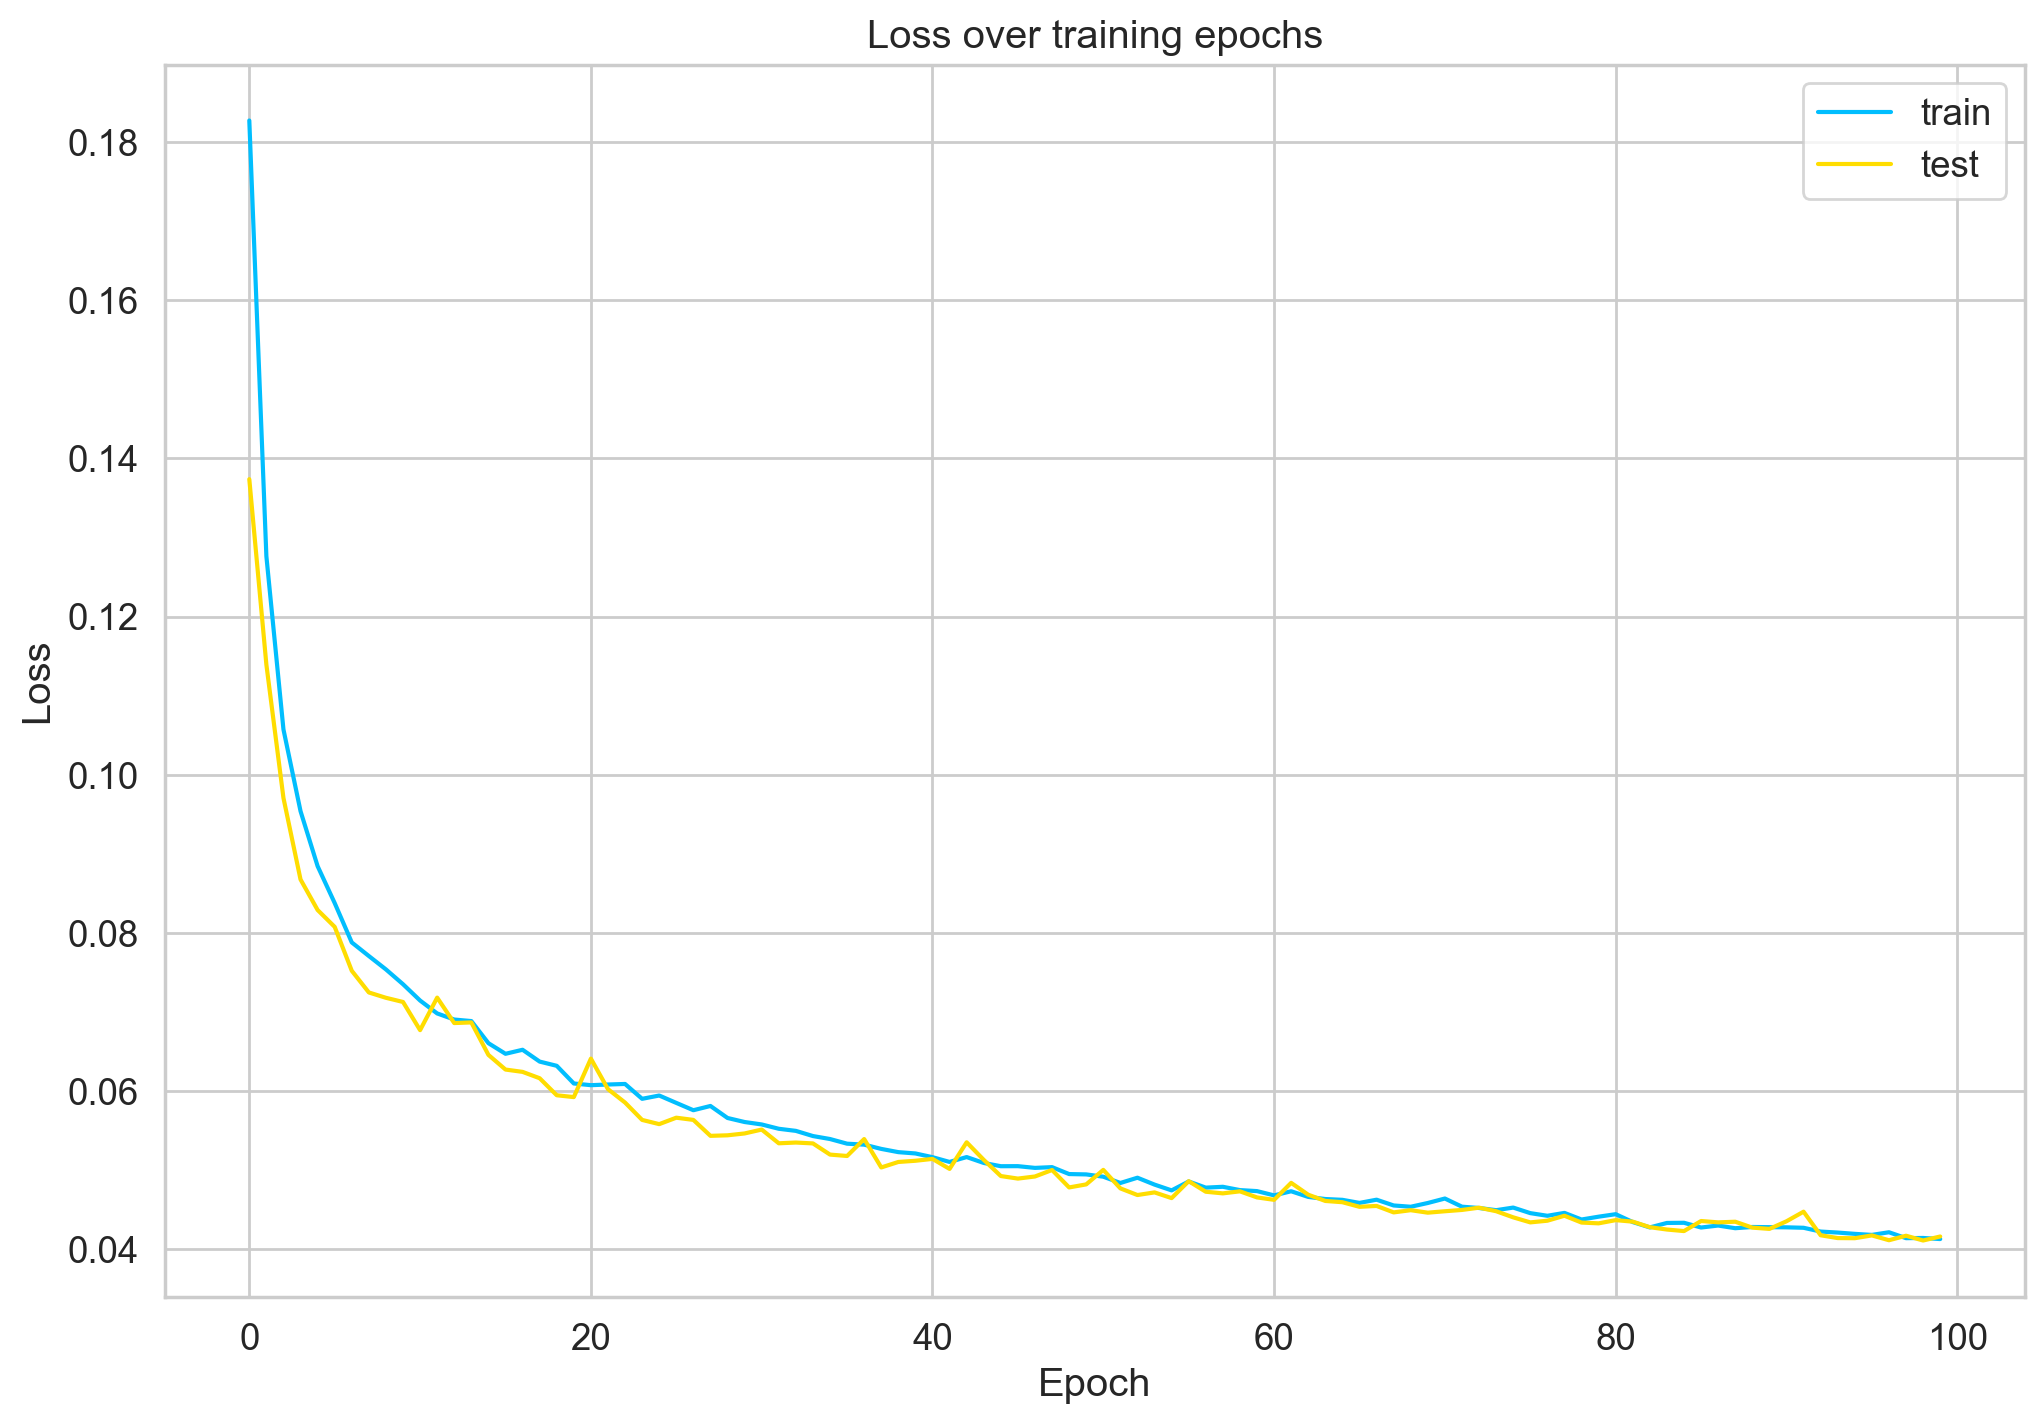

In [45]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [46]:
embedding_list = {}
output_list = {}
with torch.no_grad():
    for in_seq,tar_seq,action,vid_size in tqdm(test_dl):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for seq,emb,action in zip(seq_pred.unbind(0),embedding.unbind(0),action.unbind(0)):
                try:
                    if len(embedding_list[int(action)])<=50:
                        embedding_list[int(action)].append(emb)
                        output_list[int(action)].append(seq)
                except KeyError:
                    embedding_list[int(action)] = [emb]
                    output_list[int(action)] = [emb]

        
            
        
        #embedding_list[]

100%|██████████| 45/45 [00:15<00:00,  2.83it/s]


In [47]:
def draw_heatmaps(arr_list,nrows=2,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().cpu().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

In [48]:
draw_heatmaps(embedding_list[11])

ValueError: Sample larger than population or is negative

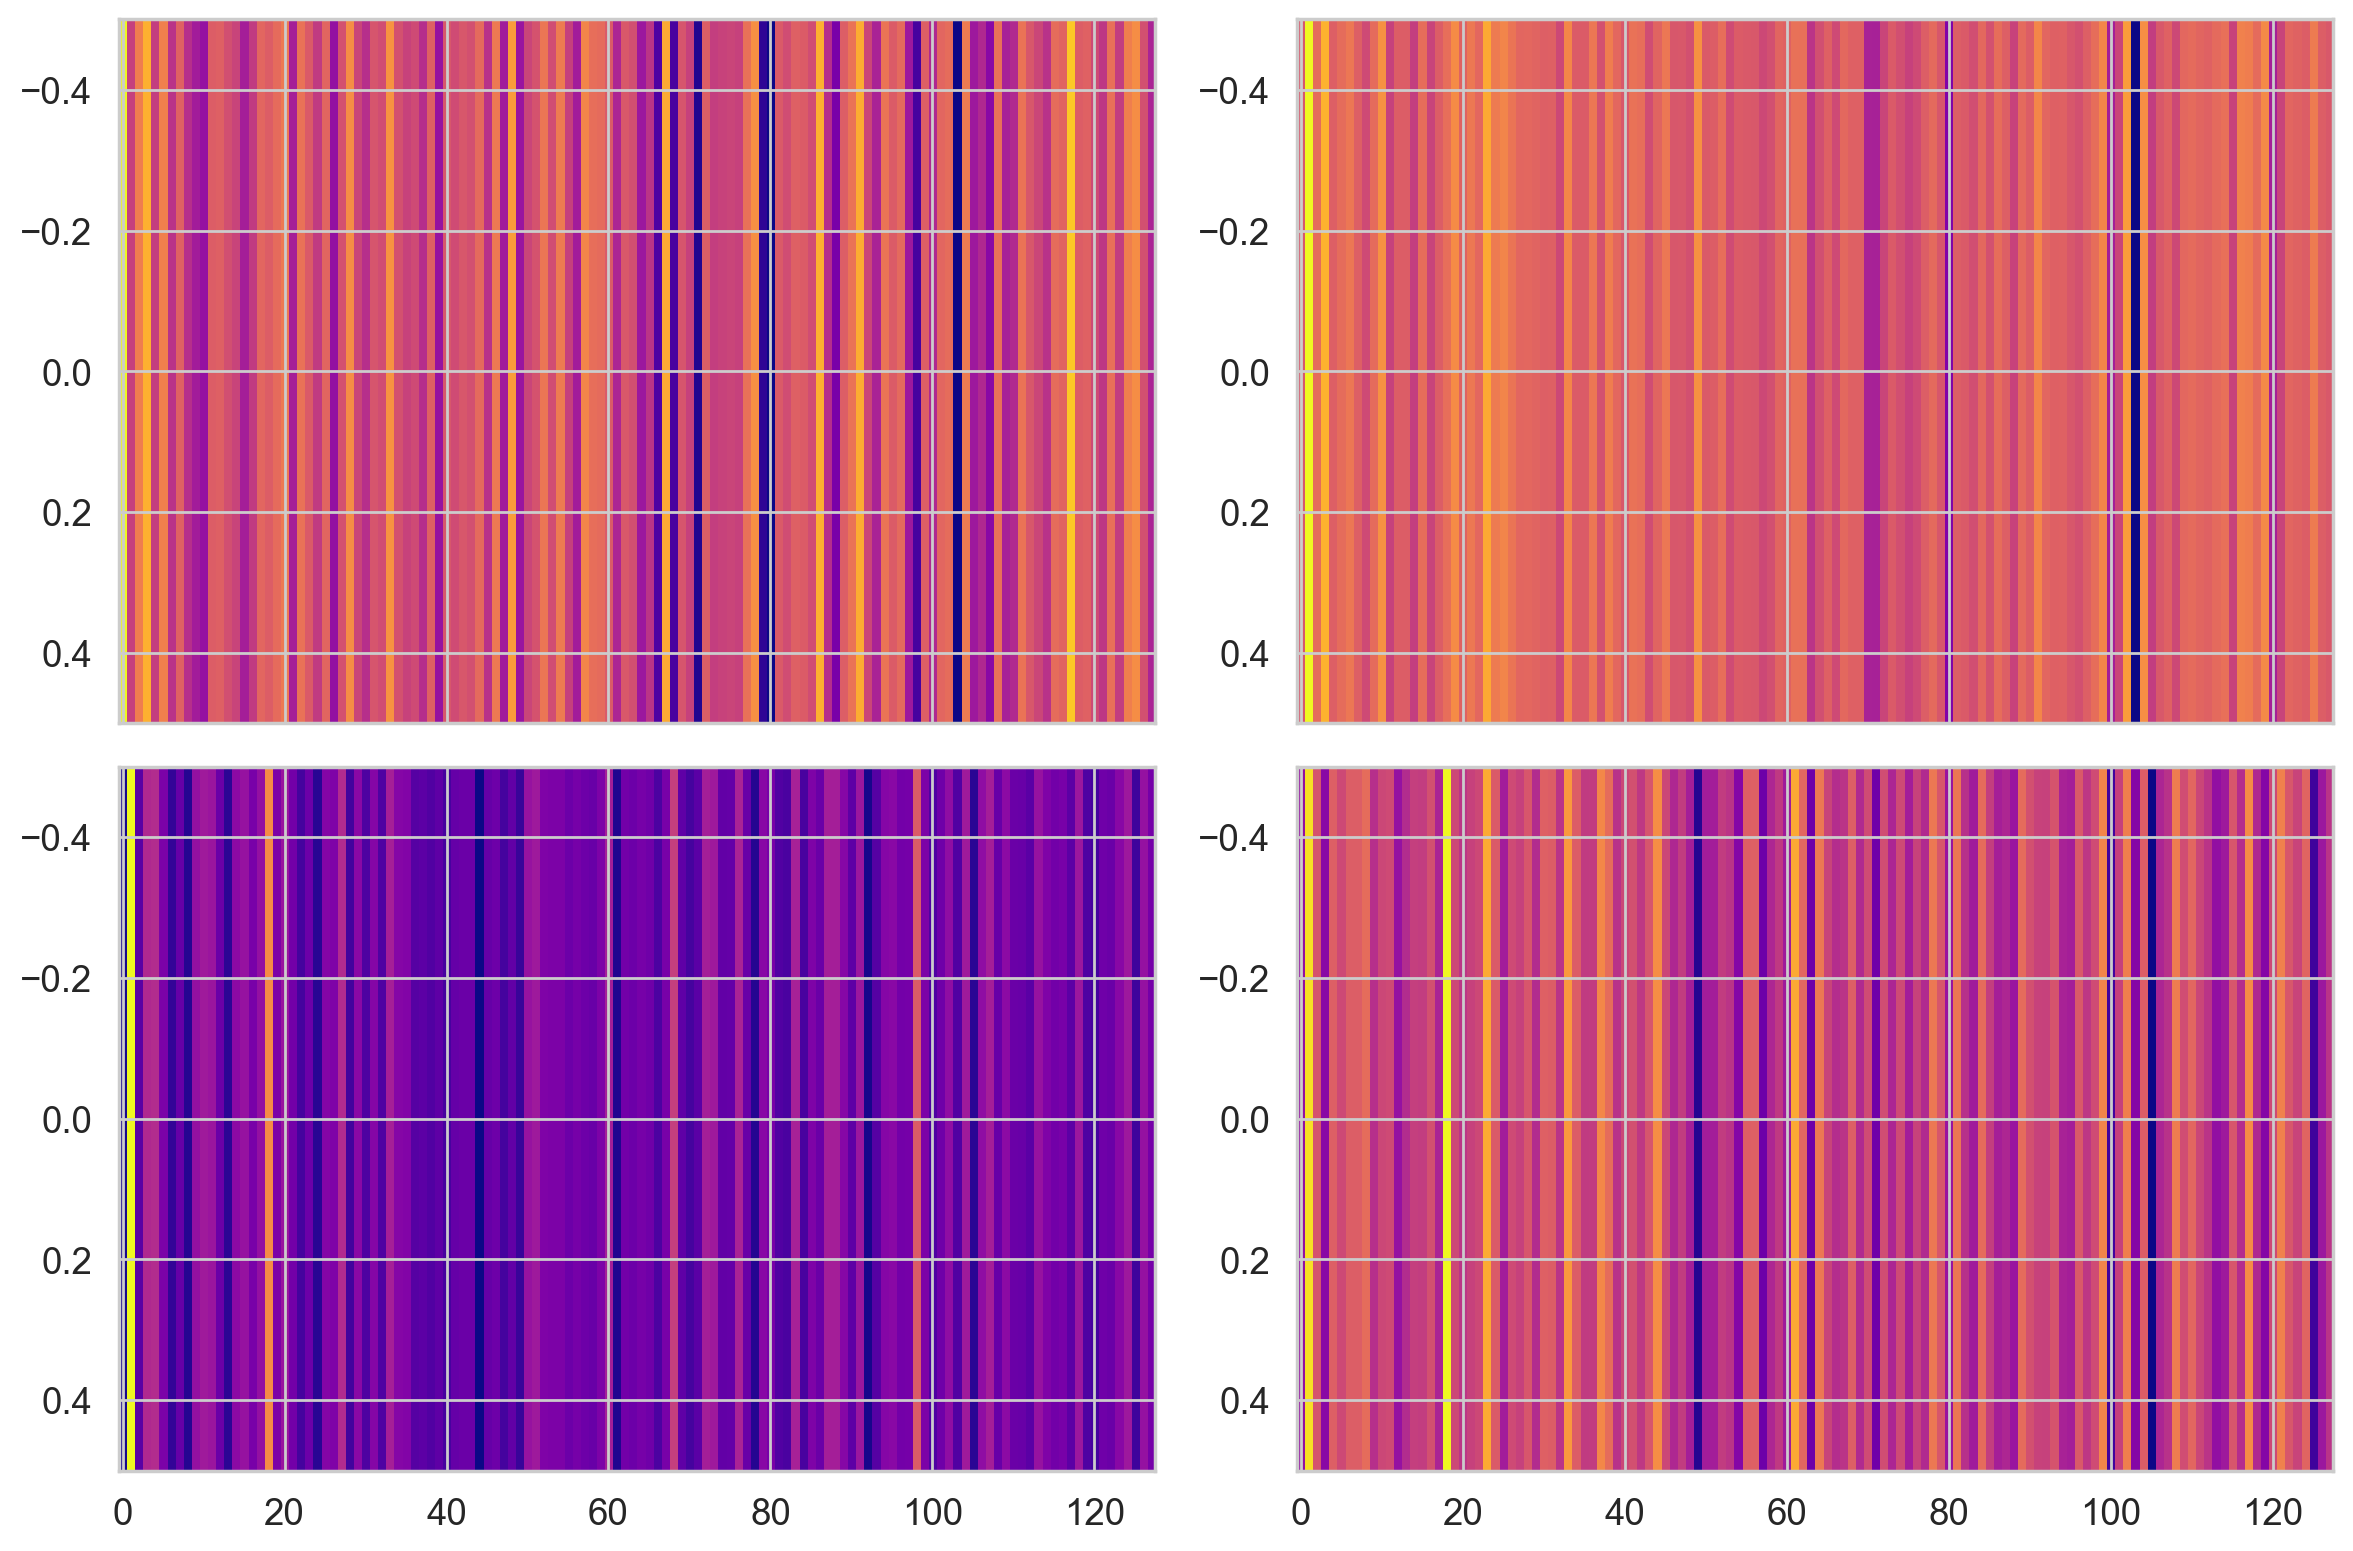

In [49]:
draw_heatmaps(embedding_list[22])

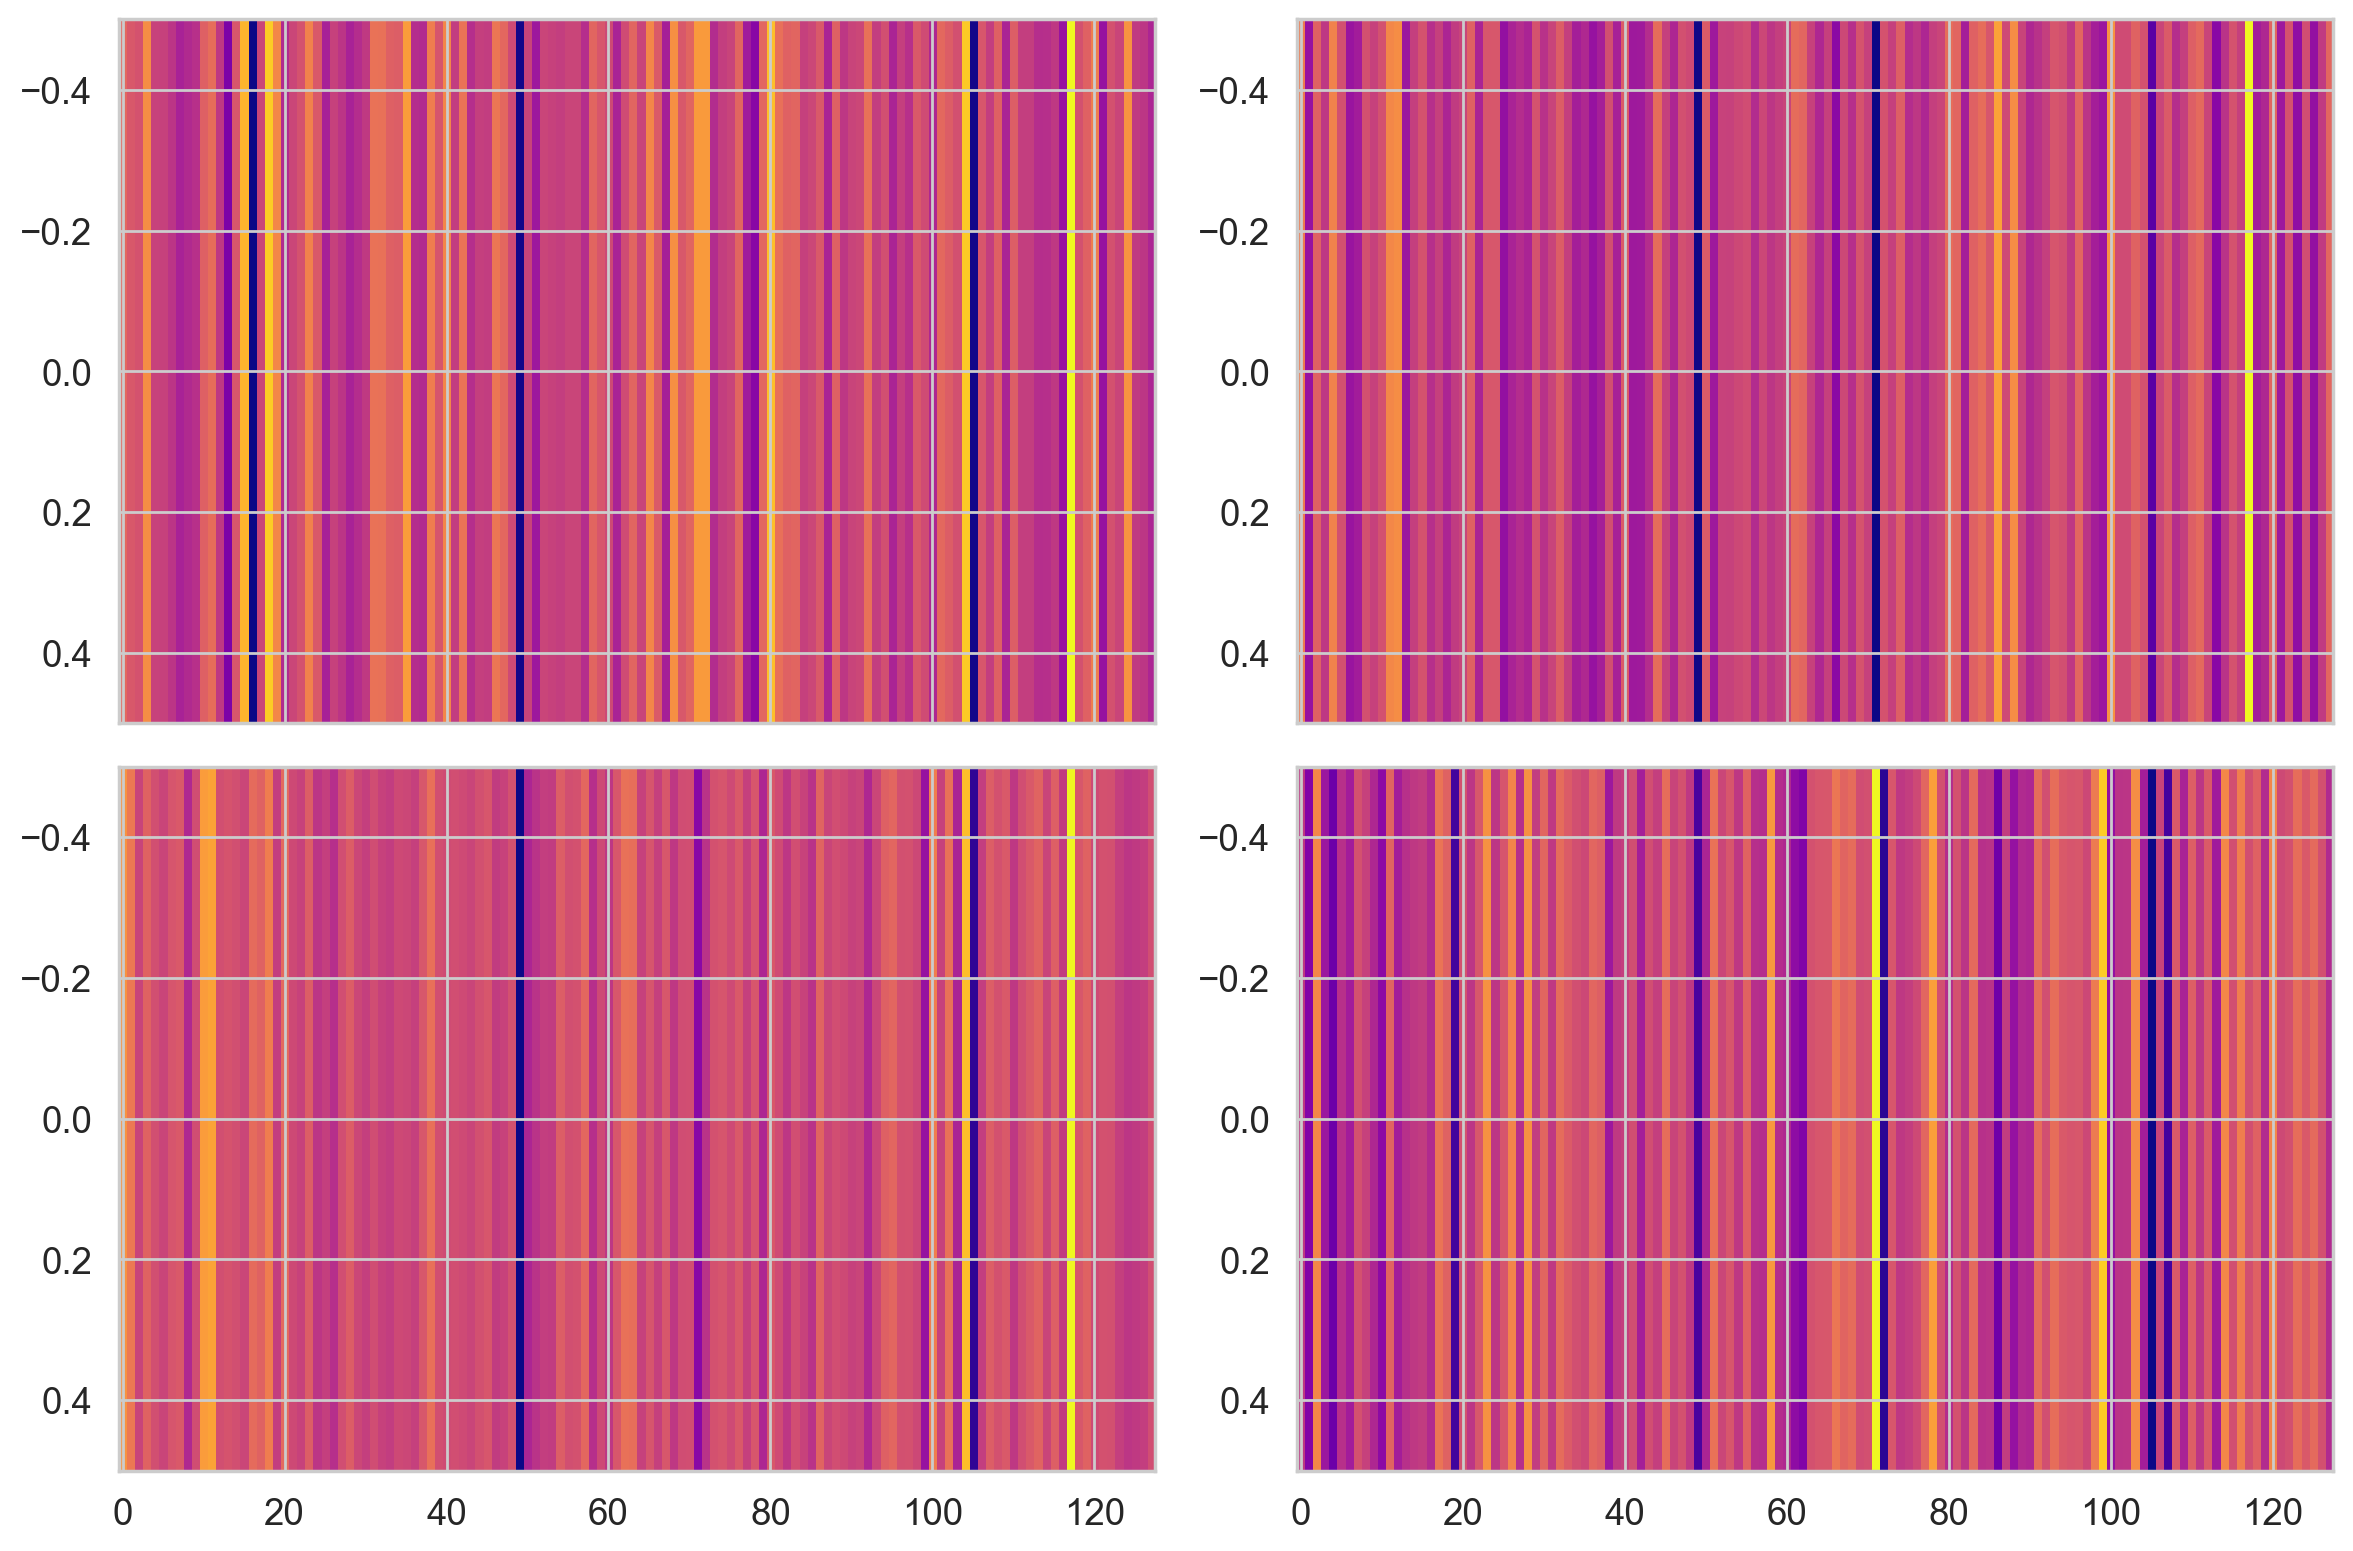

In [50]:
draw_heatmaps(embedding_list[16])

In [51]:
def gen_video_from_embeddings(embedding,model,save_file):
    seq_out = model.decoder(embedding.repeat(batch_size,1,1))
    gen_video(seq_out[0].detach().numpy(), save_file, 400, 400)

In [52]:
with torch.no_grad():
    for __id,(in_seq,tar_seq,action,vid_size) in tqdm(enumerate(test_dl)):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for __id,(input_vid,output_vid,action) in enumerate(zip(in_seq.unbind(0),seq_pred.unbind(0),action.unbind(0))):
            os.makedirs(f"{test_vids}/{int(action)}",exist_ok=True)

            

        
            
        
        #embedding_list[]

45it [00:22,  2.03it/s]


In [55]:
gen_video_from_embeddings(embedding_list[4][10],model,"embed_video.mp4")

IndexError: list index out of range

In [ ]:
test_emb = 0.5*embedding_list[19][0]+0.5*embedding_list[16][0]
gen_video_from_embeddings(test_emb,model,"test_embed_video.mp4")